# High Level Pipline for GCN and GNODE for Brain State Identification

## Pipeline Overview

### 1.1 Adjacency Matrix Generation ---> 2.1 Unsupervised GCN 

### $\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ $\;\;\;\;\;\;\;\;\;\;\;\;\;$ $\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ ---> 2.2 Unsupervised GNODE ---> 3.1 Supervised MLP

[Introduction and overview should be written here]

#### High Level Classes imported:

DataManager.py DataManagerUtil.py : [insert description here]

GCN.py GCNutil.py : [insert description here]

GDE.py GDEutil.py GDEsolvers.py : [insert description here]

MLP.py : [insert description here]

In [50]:
%load_ext autoreload
%autoreload 2
#Custom Files
from DataManager import dataManager
from DataManagerUtil import *
import GCN as GCN
import GCNutil as GCNutil
import GDE as GDE
import GDEutil as GDEutil
import GDEsolvers as GDEsolvers
import MLP as MLP

#Standard Libraries
# Torch
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
#Numpy
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Dataset:

[A short description here]

name: X_test
shape: (640, 50, 1830)
-----------------------
name: X_train
shape: (640, 50, 1804)
-----------------------
name: clip_sizes_test
shape: (2, 70)
-----------------------
name: clip_sizes_train
shape: (2, 70)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 1830)
-----------------------
name: sel_win_nums_train
shape: (1, 1804)
-----------------------
name: soz_ch_ids
shape: (22, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 1830)
-----------------------
name: y_train
shape: (1, 1804)
-----------------------
print sample EGG signal from one node:


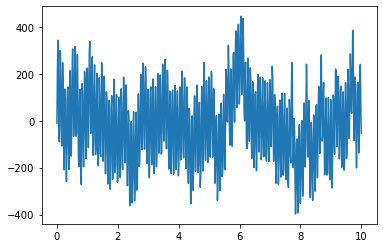

In [40]:
#Loading everything from the dataset
filepath = 'datasets\pat_FR_264.mat' #264 253 620
variables = load_patient_data(filepath, verbose = True)

In [35]:
#OPTIONAL: Shuffle the dataset
variables, indices = shuffle_train_test(variables, train_ratio = 0.5, print_summary = True)

X_train: (640, 31, 1456)
X_test: (640, 31, 1457)
y_train: (1, 1456) Positive labes: 151.0
y_test: (1, 1457) Positive labes: 170.0


In [36]:
#OPTIONAL: Remove Overlapping Parts
variables = remove_overlap(variables)

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

## 1.1 Adjacency Matrix Generation

[short description here]

##### 1.1.1 Create the datamanager object that computes the covariance matrix for you.

In [41]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))

--------data manager successfully initialized--------


##### 1.1.2 Visualize the mean covariance matrix across all training samples

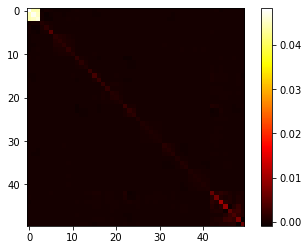

In [42]:
show_heat_map(dm.P_avg_train)

##### 1.1.3 Create DAD from dm by setting the threshold n. repeating this untill a desireble "n" value is found.

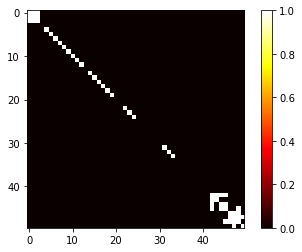

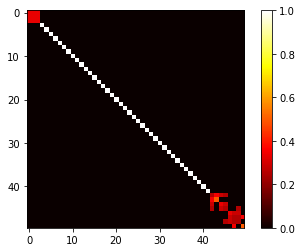

In [43]:
n = 1*10**-3
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))
Araw = dm.A_train

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

## 2.1 Unsupervised Graph Convolutional Neural Network (GCN)

[short description here]

##### 2.1.1 Declare Parameters for GCN

In [44]:
#create new model
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test
parameters = {
    'body': dm.X_train.shape[2],
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'n_layers': 2,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
print(parameters)
checkpoint = {'parameters': parameters}

{'body': 640, 'M': 1804, 'batch_size': 128, 'n_layers': 2, 'num_epochs': 1, 'learning_rate': 0.001, 'weight_decay': 0.005}


##### 2.1.2 Train GCN

In [47]:
#strongly recommand cpu because its only one epoch training time and CUDA some times run out of memory if you retrain multiple times
device_name = 'cpu'
GCNmodel, GCNcheckpoint = GCNutil.train_GCN(A, X_train, X_test, checkpoint, device_name = device_name, load = False, print_summary = True)

device set to cpu


  0%|          | 0/15 [00:00<?, ?it/s]

Net(
  (head): GCN (640,640)
  (layers): ModuleList(
    (0): GCN (640,640)
  )
  (tail): SimularityMatrix (1280)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GCN-1              [-1, 31, 640]         410,240
               GCN-2              [-1, 31, 640]         410,240
  SimularityMatrix-3               [-1, 31, 31]           1,280
Total params: 821,760
Trainable params: 821,760
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 72.73
Forward/backward pass size (MB): 0.31
Params size (MB): 3.13
Estimated Total Size (MB): 76.18
----------------------------------------------------------------


  7%|▋         | 1/15 [00:00<00:09,  1.41it/s]

 13%|█▎        | 2/15 [00:01<00:08,  1.46it/s]

 20%|██        | 3/15 [00:02<00:08,  1.47it/s]

 27%|██▋       | 4/15 [00:02<00:07,  1.46it/s]

 33%|███▎      | 5/15 [00:03<00:06,  1.47it/s]

 40%|████      | 6/15 [00:04<00:06,  1.47it/s]

 47%|████▋     | 7/15 [00:04<00:05,  1.49it/s]

 53%|█████▎    | 8/15 [00:05<00:04,  1.49it/s]

 60%|██████    | 9/15 [00:06<00:04,  1.50it/s]

 67%|██████▋   | 10/15 [00:06<00:03,  1.51it/s]

 73%|███████▎  | 11/15 [00:07<00:02,  1.51it/s]

 80%|████████  | 12/15 [00:07<00:01,  1.53it/s]

 87%|████████▋ | 13/15 [00:08<00:01,  1.55it/s]

100%|██████████| 15/15 [00:09<00:00,  1.61it/s]

Epoch: 1   Batch: 15 of size 128   Train loss: 189.33819580078125   Valid loss: 180.692626953125


In [48]:
#optional: saving the model
GCNutil.save_ckp(checkpoint, "models/GCNtest1.pt")

model saved


##### 2.1.3 Visualize some simularity matrices generated by GCN (a visual evaluation and sanity check)

In [51]:
GCNmodel.eval()
test_pred = GCNmodel(torch.from_numpy(X_train[:128, :,:]).float().to(device_name), torch.from_numpy(A).float().to(device_name))

sample 0   label, 0.0


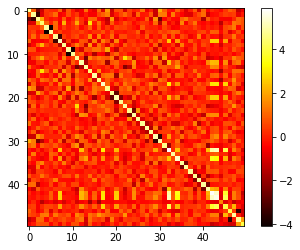

sample 1   label, 0.0


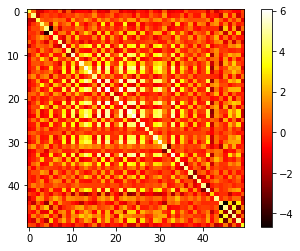

sample 2   label, 0.0


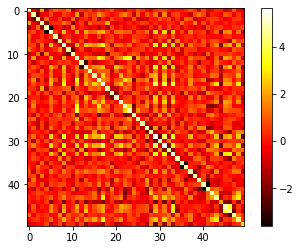

sample 3   label, 0.0


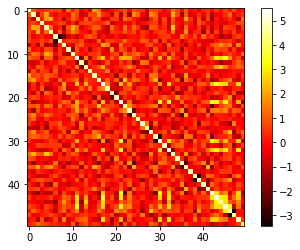

sample 4   label, 0.0


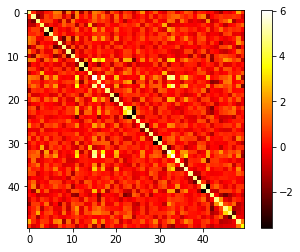

sample 5   label, 0.0


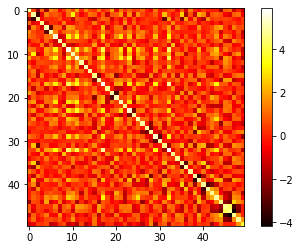

sample 6   label, 0.0


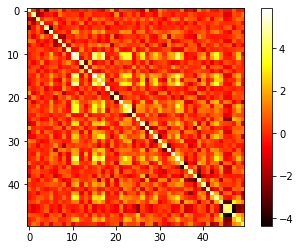

sample 7   label, 0.0


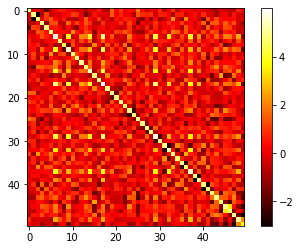

sample 8   label, 0.0


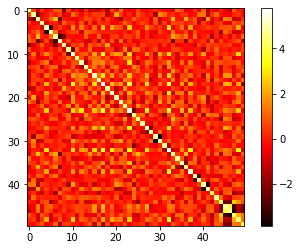

sample 9   label, 0.0


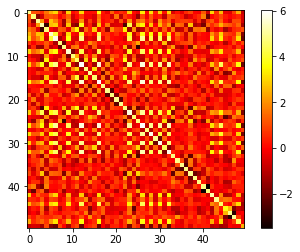

In [53]:
for i in range(10):
    print("sample", i, "  label,", dm.Y_train[i,0])
    show_heat_map(test_pred[i,:,:].cpu().detach().numpy())